# BULK DENSITY
Reads derived_posteriors.hdf5 fromt TRADES-analysis and computes bulk densities.
Provides planetary radius with errors in the same unit of the masses in the hdf5 file.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
import os
import h5py
import pyconstants as cst

Reads hdf5 file with derived posteriors and selects only masses.

In [2]:
def read_derpost(h5file):
    
    of = h5py.File(h5file, 'r')
    
    der_names_a = of['derived_names'][...]
    der_units_a = of['units_derived'][...]
    # keeps only masses: m#
    nder = np.shape(der_names_a)[0]
    idx_m = [i for i in range(0,nder) if der_names_a[i][0] == 'm' and der_names_a[i][1] != 'A']
    m_names = [der_names_a[i] for i in idx_m]
    m_units = [der_units_a[i] for i in idx_m]
    npl = len(m_names)
    gg = of['derived_posterior']
    m_post = gg[...][:,idx_m]
    of.close()
    
    return m_names, m_units, m_post

Copy here functions to determine the number of bins in automatic... bins should be the same across the posterior.

In [3]:
# ==============================================================================
# STURGES RULE TO COMPUTE THE NUMBER OF BINS FOR HISTOGRAM
# ==============================================================================

def sturges_nbins(npost):
    '''
    Following Sturges' rule:
    nbins = log2(n) + 1
    '''
    nbins = np.ceil(np.log2(np.float64(npost))).astype(int) + 1

    return nbins

# ==============================================================================
# FREEDMAN-DIACONIS RULE TO COMPUTE THE NUMBER OF BINS FOR HISTOGRAM
# ==============================================================================

def freedman_diaconis_nbins(x):
    '''
    Following Freedman-Diaconis rule:
    width = 2 * IRQ / n^1/3
    nbins = [ (max-min) / width ]
    '''
    q75 = np.percentile(x, 75., interpolation='midpoint')
    q25 = np.percentile(x, 25., interpolation='midpoint')
    irq = np.abs(q75-q25)
    nx = np.float64(np.shape(x)[0])
    width = 2. * irq / np.power(nx,1./3.)
    nbins = np.ceil(np.abs(np.max(x)-np.min(x))/width).astype(int)

    return nbins

# ==============================================================================
# DOANE'S FORMULA TO COMPUTE THE NUMBER OF BINS FOR HISTOGRAM
# ==============================================================================

def doane_nbins(x):
    '''
    Doane's formula:
     nbins = 1 + lon2(n) + log2(1 + |g1|/s_g1)
     n: number of points/sample
     g1 = 3rd-moment-skewness
     s_g1 = sqrt( (6 x (n-2)) / ((n+1) x (n+3)) )
    '''
    nxf = np.float64(np.shape(x)[0])
    mux = np.mean(x)
    stdx = np.std(x, ddof=1)
    g1 = np.mean(((x - mux) / stdx) ** 3)  # skew
    s_g1 = np.sqrt(6. * (nxf - 2.) / ((nxf + 1.) * (nxf + 3.)))
    #print nxf
    #print mux,stdx
    #print g1, s_g1
    nbins = int(1. + np.log2(nxf) + np.log2(1. + np.abs(g1) / s_g1))

    return nbins

# ==============================================================================
# GIVEN THE POSTERIOR IT SELECT THE PROPER NBINS FOR ALL THE PARAMETER DISTRIBUTIONS
# ==============================================================================

def get_auto_bins(posterior):

    npost, nfit = np.shape(posterior)
    # call Freedman-Diaconis rule
    nbins_fd = [freedman_diaconis_nbins(posterior[:,ifit]) for ifit in range(nfit)]
    # doane's formula
    nbins_doa = [doane_nbins(posterior[:,ifit]) for ifit in range(nfit)]
    # and Sturges' rule
    nbins = int(np.mean([min(nbins_fd), min(nbins_doa), sturges_nbins(npost)]))

    return nbins

# ==============================================================================
# HIGH DENSITY INTERVALS - DOING BAYESIAN DATA ANALYSIS by Kruschke
# ==============================================================================

def calculate_hdi(x, nbins, alpha=[0.05], mode_output=False):
  
    # 68.27% (15.87th-84.13th) ==> alpha = 1. - 0.6827 = 0.3173
    # 95.44% ( 2.28th-97.72th) ==> alpha = 1. - 0.9544 = 0.0456
    # 99.74% ( 0.13th-99.87th) ==> alpha = 1. - 0.9974 = 0.0026

    counts, bin_edges = np.histogram(x, bins=nbins)
    #nbins = len(counts)

    bin_width = bin_edges[1] - bin_edges[0]
    hwidth = 0.5*bin_width
    bin_mid = [bin_edges[ibin]+hwidth for ibin in range(nbins)]

    # probability mass distribution = (counts / ndata)
    # probability density = probability mass distribution / bin_width
    pmd = np.asarray(counts)/np.float64(np.shape(x)[0])
    #pdd = pmd / bin_width
    spmd = np.sort(pmd)[::-1]
    hdi_ci = []
    for ialpha in alpha:
        lowestHeightIdx = np.min(np.where(np.cumsum(spmd) > (1. - ialpha)))
        lowestHeight = spmd[lowestHeightIdx]
        bin_sel = np.asarray(bin_mid)[pmd >= lowestHeight]
        hdi_l = np.min(bin_sel) - hwidth
        hdi_u = np.max(bin_sel) + hwidth
        hdi_ci.append([hdi_l, hdi_u])

    if(mode_output):
        max_bin = np.argmax(np.array(counts))
        #if (max_bin == 0 or max_bin == nbins):
          #ext_bin = 0
        #elif (max_bin == 1 or max_bin == nbins-1):
          #ext_bin = 1
        #else:
          #ext_bin = 2
        #sel_bin = np.logical_and(x >= bin_edges[max_bin-ext_bin],
                                 #x < bin_edges[max_bin+ext_bin+1])
        sel_bin = np.logical_and(x >= bin_edges[max_bin],
                                 x < bin_edges[max_bin+1])

        mode = np.mean(x[sel_bin])
        hdi_ci.append(mode)
  
    return hdi_ci

Computes density of one planetary mass posterior in Earth masses provided the radius (with neg. and pos. error) in same unit.

In [4]:
def bulk_density(m, r):
    
    rho = m / np.power(r, 3)
    
    return rho
    
def bulk_density_post(m_post, r, r_ne, r_pe, seed=None):
    
    np.random.RandomState(seed=seed)
    
    npost = np.shape(m_post)[0]
    # computes gaussian for radius r_v
    gnorm = np.random.normal(0., 1, size=npost)
    rg = r + gnorm*r_pe
    neg = gnorm < 0.
    rg[neg] = r + gnorm[neg]*np.abs(r_ne)

    rho_post = m_post / np.power(rg, 3)
    # not using the 4pi/3 because it is expressed in unit of m and r, eg. rho_earth
    
    return rg, rho_post

Computes the hdi and plots the distributions.

In [5]:
def plot_hdi(ax, hdi1, hdi2, hdi3):
    
    ax.axvline(hdi1[0], color='black', ls='-', lw=0.8)
    ax.axvline(hdi1[1], color='black', ls='-', lw=0.8)
    
    ax.axvline(hdi2[0], color='gray', ls='--', lw=0.8)
    ax.axvline(hdi2[1], color='gray', ls='--', lw=0.8)
    
    ax.axvline(hdi3[0], color='lightgray', ls='--', lw=0.8)
    ax.axvline(hdi3[1], color='lightgray', ls='--', lw=0.8)
    
    return 

def print_hdi(alpha, hdi, rho_gcmc):
    
    
    a = 'HDI(%5.2f): rho = [%.4f , %.4f] \\rho_\oplus' %(100.*(1.-alpha), hdi[0], hdi[1])
    b = '%s = [%.4f , %.4f] g/cm^3' %(a, hdi[0]*rho_gcmc, hdi[1]*rho_gcmc)
    print b
    
    return

def hdi_and_distributions(rho, m_post, r_post, rho_post, body_id=2, nbins=33, do_plot=True):
    
    vol_earth = 4.*np.pi*np.power(cst.Rear*1.e3, 3)/3.
    rho_earth_kgmc = cst.Mear/vol_earth
    kmc2gcmc = 1.e3 / np.power(1.e2, 3)
    rho_earth_gcmc = rho_earth_kgmc * kmc2gcmc
    
    # HDI at 68.27% 95.44% 99.74%
    alpha = [0.3173, 0.0456, 0.0026]
    
    hdi1 = calculate_hdi(rho_post, nbins, alpha=[alpha[0]], mode_output=False)[0]
    hdi2 = calculate_hdi(rho_post, nbins, alpha=[alpha[1]], mode_output=False)[0]
    hdi3 = calculate_hdi(rho_post, nbins, alpha=[alpha[2]], mode_output=False)[0]
    
    rho_gcm3 = rho*rho_earth_gcmc
    
    print
    print 'Earth density: \\rho_\oplus = %.3f kg/m^3 = %.6f g/cm^3' %(rho_earth_kgmc, rho_earth_gcmc)
    print '   density: rho = %.4f \\rho_\oplus = %.4f g/cm^3' %(rho, rho_gcm3)
    print_hdi(alpha[0], hdi1, rho_earth_gcmc)
    print_hdi(alpha[1], hdi2, rho_earth_gcmc)
    print_hdi(alpha[2], hdi3, rho_earth_gcmc)
    print ' **rho = %.4f _{%.4f} ^{%.4f} g/cm^{3}' %(rho_gcm3, hdi1[0]*rho_earth_gcmc-rho_gcm3, hdi1[1]*rho_earth_gcmc-rho_gcm3)

    print
    
    letters = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'.split()
    lpl = letters[body_id-1]
    mlabel = '$M_\mathrm{%s}\, (M_\oplus)$' %(lpl)
    rlabel = '$R_\mathrm{%s}\, (R_\oplus)$' %(lpl)
    rholabel = '$\\rho_\mathrm{%s}\, (\\rho_\oplus)$' %(lpl)
    
    if(do_plot):
        nrows, ncols = 2,2

        fig=plt.figure(figsize=(14,10))

        ax = plt.subplot2grid((nrows, ncols), (0,0), rowspan=1, colspan=1)
        ax.hist(m_post, bins=nbins, density=True, stacked=True)
        ax.set_ylabel('prob. density', fontsize=10)
        ax.set_xlabel(mlabel, fontsize=14)

        ax = plt.subplot2grid((nrows, ncols), (0,1), rowspan=1, colspan=1)
        ax.hist(r_post, bins=nbins, density=True, stacked=True)
        ax.set_ylabel('prob. density', fontsize=10)
        ax.set_xlabel(rlabel, fontsize=14)

        ax = plt.subplot2grid((nrows, ncols), (1,0), rowspan=1, colspan=2)
        ax.hist(rho_post, bins=nbins, density=True, stacked=True)
        ax.set_ylabel('prob. density', fontsize=10)
        ax.set_xlabel(rholabel, fontsize=14)
        plot_hdi(ax, hdi1, hdi2, hdi3)
        ax.axvline(rho, color='C1', ls='-', lw=1.8)
    
    return

#### Kepler-9

In [6]:
root_folder = os.path.abspath('/data2/borsato/TRADESsimulations')
# main_folder = os.path.join(root_folder, 'Kepler-9/EMCEE/2018-06-20_K9_emcee_test_001/2108-06-20_run_001/')
# main_folder = os.path.join(root_folder, 'Kepler-9/EMCEE/2018-07-19_K9_emcee_noRV_001/2018-09-13_run_001/noRV/')
main_folder = os.path.join(root_folder, 'Kepler-9/EMCEE/2018-11-13_K9_emcee_noRV_001/2018-11-13_run_001/run_full/RV/')
par_folder = os.path.join(main_folder, '0668_sim')
der_file = os.path.join(main_folder, 'derived_posterior.hdf5')
m_names, m_units, m_post = read_derpost(der_file)

Computes the nbins from m_post.

In [7]:
nbins = get_auto_bins(m_post)

# Kepler-9b

Earth density: \rho_\oplus = 5494.957 kg/m^3 = 5.494957 g/cm^3
   density: rho = 0.0762 \rho_\oplus = 0.4186 g/cm^3
HDI(68.27): rho = [0.0604 , 0.0875] \rho_\oplus = [0.3318 , 0.4810] g/cm^3
HDI(95.44): rho = [0.0498 , 0.1041] \rho_\oplus = [0.2738 , 0.5722] g/cm^3
HDI(99.74): rho = [0.0423 , 0.1252] \rho_\oplus = [0.2323 , 0.6882] g/cm^3
 **rho = 0.4186 _{-0.0868} ^{0.0624} g/cm^{3}



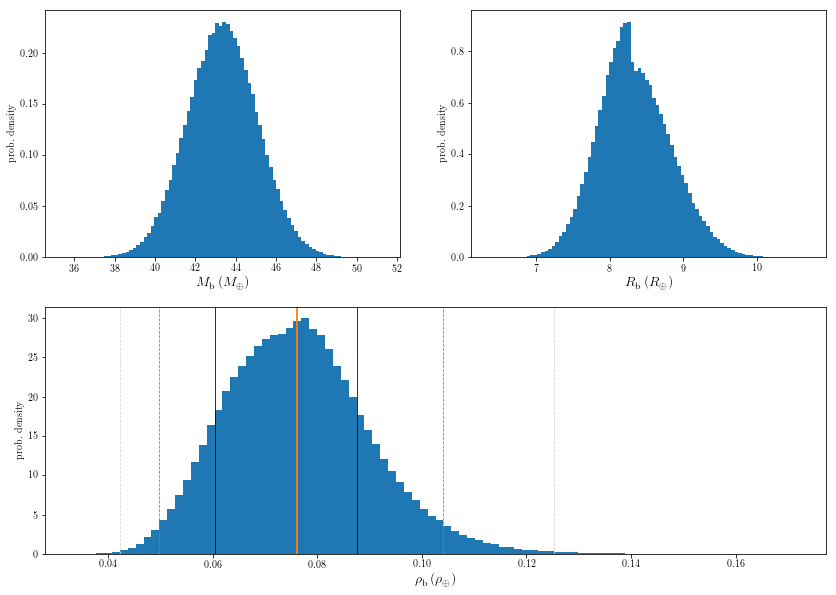

In [8]:
# Kepler-9b
m  = 43.4 # M_Earth unit
# r, r_ne, r_pe = 8.48, -0.35, +0.35 # R_Earth unit
r, r_ne, r_pe = 8.29, -0.43, +0.54 # R_Earth unit
rho = bulk_density(m, r)
print '# Kepler-9b'
r_post, rho_post = bulk_density_post(m_post[:,0], r, r_ne, r_pe, seed=2018)
hdi_and_distributions(rho, m_post[:,0], r_post, rho_post, body_id=2, nbins=nbins)

# Kepler-9c

Earth density: \rho_\oplus = 5494.957 kg/m^3 = 5.494957 g/cm^3
   density: rho = 0.0567 \rho_\oplus = 0.3115 g/cm^3
HDI(68.27): rho = [0.0456 , 0.0658] \rho_\oplus = [0.2504 , 0.3615] g/cm^3
HDI(95.44): rho = [0.0366 , 0.0770] \rho_\oplus = [0.2010 , 0.4232] g/cm^3
HDI(99.74): rho = [0.0310 , 0.0916] \rho_\oplus = [0.1702 , 0.5034] g/cm^3
 **rho = 0.3115 _{-0.0611} ^{0.0500} g/cm^{3}



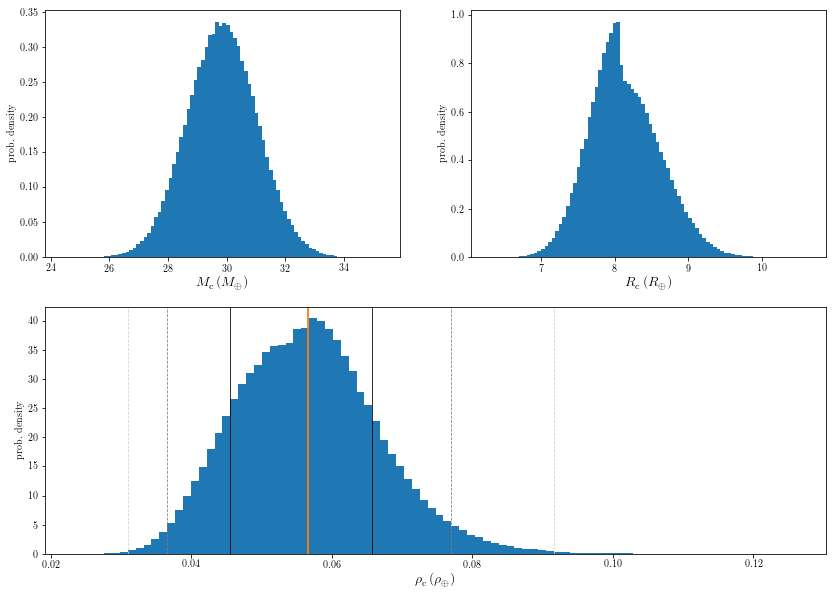

In [9]:
# Kepler-9c
# m  = 30.0 # M_Earth unit
m  = 29.9 # M_Earth unit
# r, r_ne, r_pe = 8.27, -0.36, +0.35 # R_Earth unit
r, r_ne, r_pe = 8.08, -0.41, +0.54 # R_Earth unit
rho = bulk_density(m, r)
print '# Kepler-9c'
r_post, rho_post = bulk_density_post(m_post[:,1], r, r_ne, r_pe, seed=2018)
hdi_and_distributions(rho, m_post[:,1], r_post, rho_post, body_id=3, nbins=nbins)